In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

import wandb
from custom_datasets import dataset
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

wandb_api.login()
api = wandb.Api()
run_name = "3uegu1ye"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [7]:
training_data_at = wandb.Api().artifact(
    "matiasetcheverry/microstructure-reconstruction/train_df:1_images"
)
test_data_at = wandb.Api().artifact(
    "matiasetcheverry/microstructure-reconstruction/test_df:1_images"
)
training_data_at.download()
test_data_at.download()
train_df = wandb_api.convert_table_to_dataframe(training_data_at.get("fabrics"))
train_df["photos"] = train_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
test_df = wandb_api.convert_table_to_dataframe(test_data_at.get("fabrics"))
test_df["photos"] = test_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
train_df


,id,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,orientation-1_std,orientation-2_std,...,aspectratio-0_std,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
0,Spec-197,0.356348,0.323515,0.320137,-0.017216,0.003262,-0.001308,0.314627,0.306735,0.304501,...,0.143148,0.102656,10.741075,2.938481,0.873860,0.055687,0.212789,0.087993,0.217926,[/home/matias/microstructure-reconstruction/RE...
1,Spec-344,0.347647,0.331023,0.321330,0.003530,0.002675,0.000964,0.322281,0.311201,0.305359,...,0.138008,0.124940,10.935470,2.712020,0.954486,0.083377,0.358212,0.143051,0.338746,[/home/matias/microstructure-reconstruction/RE...
2,Spec-99,0.359718,0.331703,0.308579,-0.012734,0.000141,0.003148,0.313214,0.306073,0.296053,...,0.139168,0.100356,10.947315,2.989302,0.870407,0.058849,0.212515,0.086692,0.223764,[/home/matias/microstructure-reconstruction/RE...
3,Spec-530,0.374891,0.358770,0.266340,0.239456,0.009192,0.008185,0.282298,0.283344,0.167377,...,0.133047,0.120841,11.482441,2.195267,0.928704,0.077101,0.292550,0.127101,0.141834,[/home/matias/microstructure-reconstruction/RE...
4,Spec-492,0.143142,0.139783,0.717074,0.247139,0.011478,0.001049,0.144587,0.143042,0.168408,...,0.136951,0.113757,10.953518,2.482555,0.919975,0.090867,0.277326,0.125126,0.296957,[/home/matias/microstructure-reconstruction/RE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,Spec-163,0.310736,0.349786,0.339478,-0.005327,-0.000082,0.003391,0.297220,0.305787,0.309034,...,0.138733,0.105004,10.398206,2.797734,0.877064,0.054819,0.217739,0.089788,0.216830,[/home/matias/microstructure-reconstruction/RE...
416,Spec-195,0.335551,0.339138,0.325312,-0.001358,0.011718,-0.014050,0.309818,0.312565,0.307158,...,0.143635,0.102686,13.459184,4.464352,0.847222,0.103073,0.206318,0.086632,0.385221,[/home/matias/microstructure-reconstruction/RE...
417,Spec-342,0.334104,0.331458,0.334438,0.000891,0.002602,0.011794,0.313064,0.313294,0.313087,...,0.141975,0.124556,10.969777,2.483673,0.956011,0.078309,0.353728,0.148757,0.308272,[/home/matias/microstructure-reconstruction/RE...
418,Spec-491,0.144886,0.140017,0.715096,0.251179,-0.011591,-0.003892,0.153152,0.142701,0.171072,...,0.138290,0.117119,11.570258,2.803110,0.920576,0.084933,0.278994,0.129881,0.174805,[/home/matias/microstructure-reconstruction/RE...


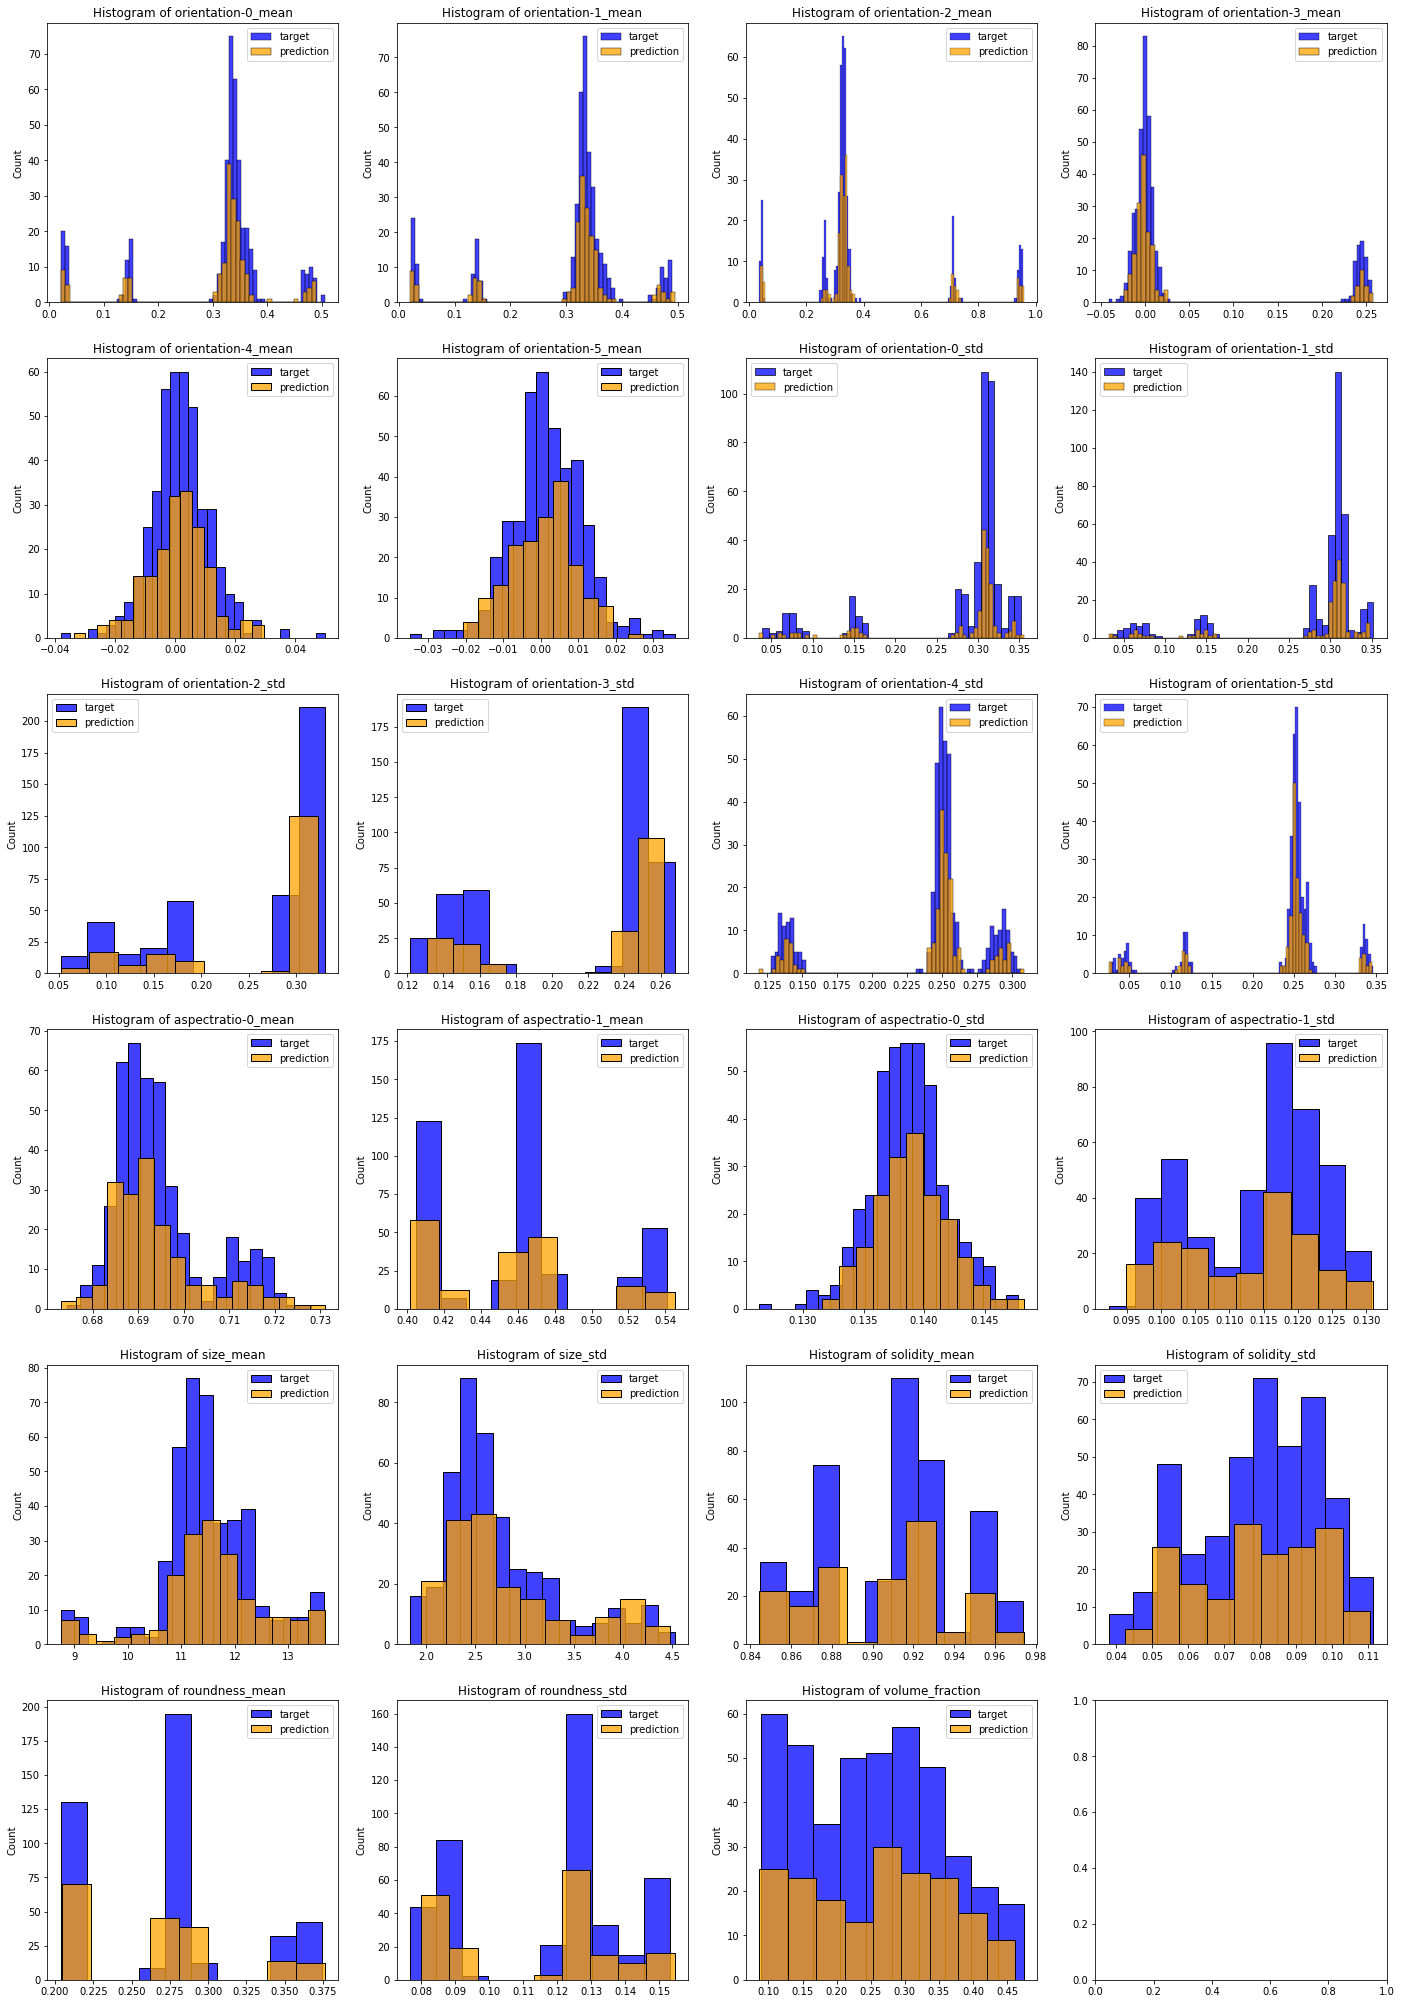

In [8]:
fig = plotting.plot_hist(
    train_df.iloc[:, 1:-1], test_df.iloc[:, 1:-1], nb_hist_per_line=4
)


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(


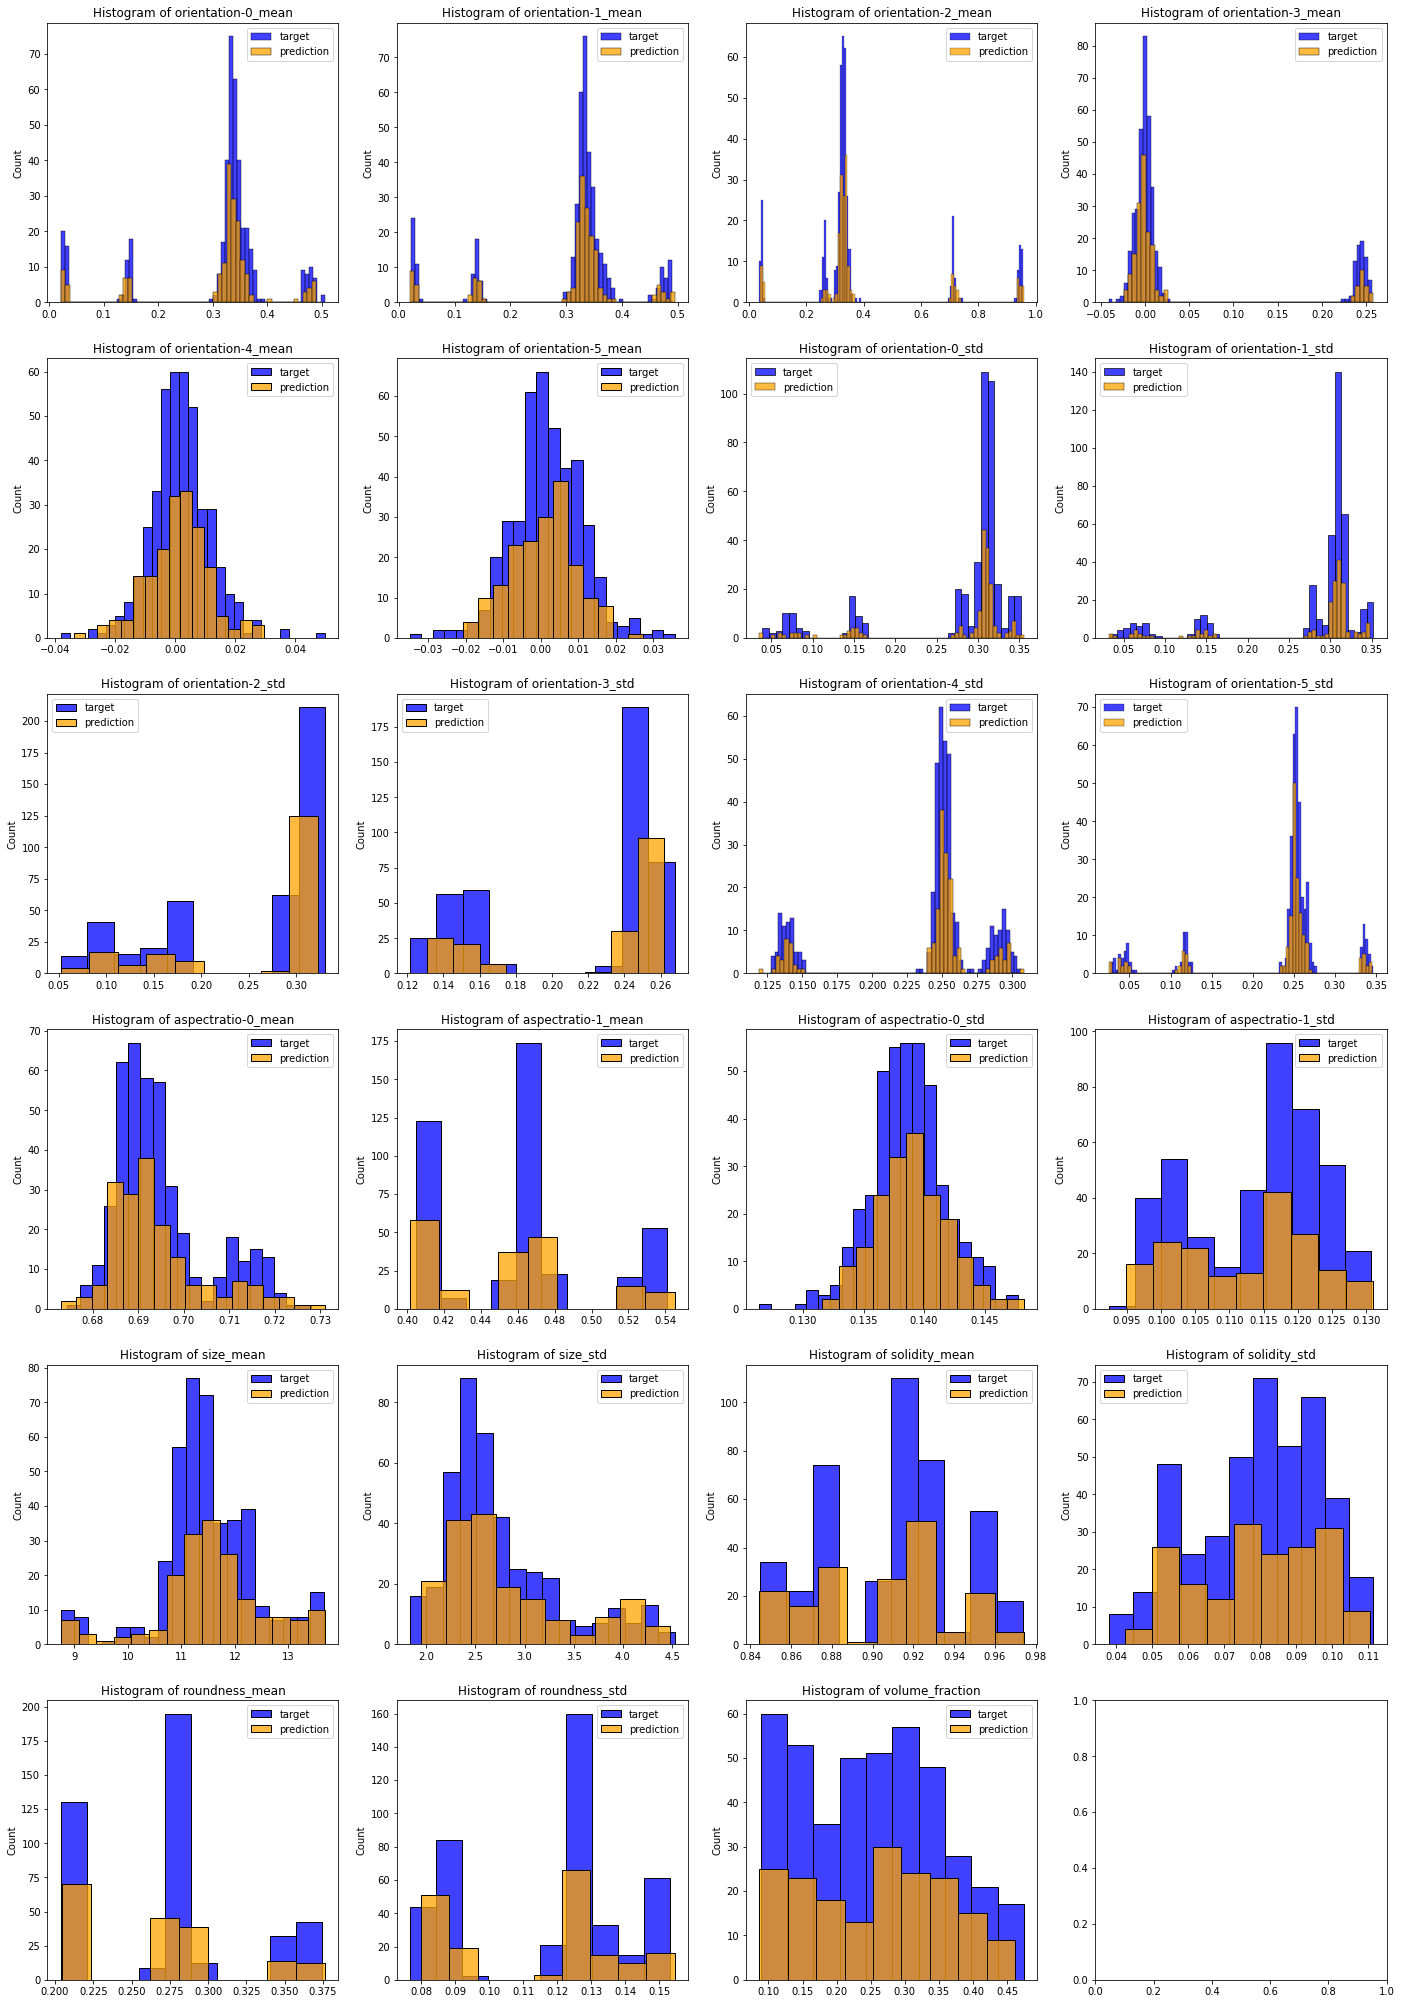

In [9]:
reload(plotting)
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(
    train_df.iloc[:, 1:-1].to_numpy()
)
weights = kde.score_samples(train_df.iloc[:, 1:-1])
weights - np.min(weights)
fig = plotting.plot_hist(
    train_df.iloc[:, 1:-1],
    test_df.iloc[:, 1:-1],
    nb_hist_per_line=4,
)
# fig, ax = plt.subplots()
# ax.hist(train_df.iloc[:, 1], bins=50)
# plt.show()
# fig, ax = plt.subplots()
# ax.hist(train_df.iloc[:, 1], bins=50, weights=)


In [6]:
noise = 0.1
# torchvision.transforms.Lambda(lambda x: x + torch.rand(x.shape))
torch.normal(0, noise)


TypeError: normal() received an invalid combination of arguments - got (int, float), but expected one of:
 * (Tensor mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (Tensor mean, float std, *, torch.Generator generator, Tensor out)
 * (float mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (float mean, float std, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


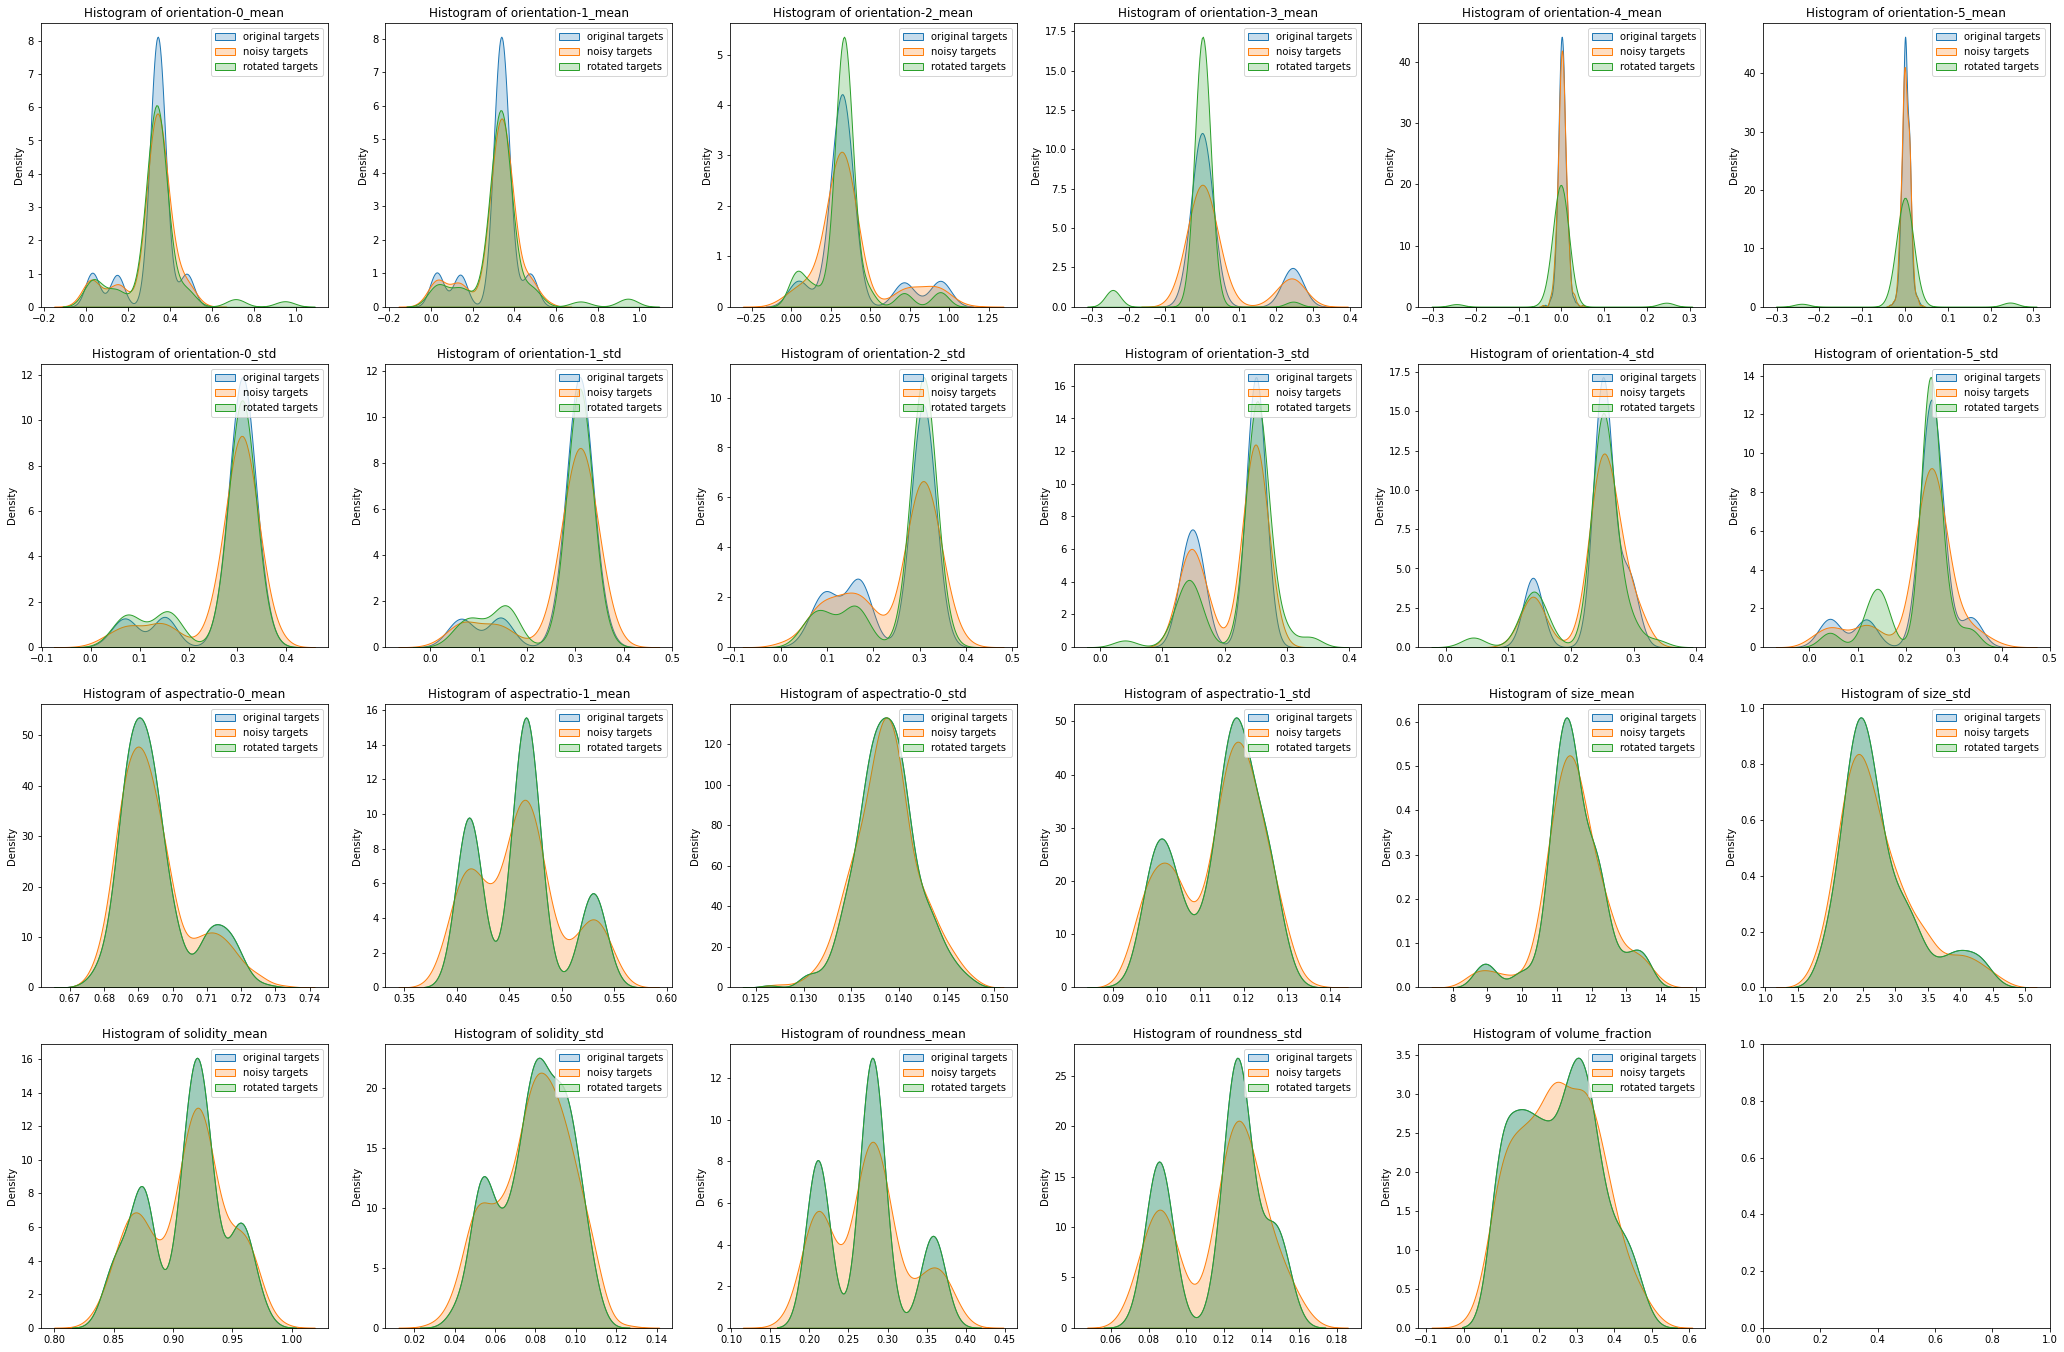

In [18]:
import numpy as np
from functools import partial


def rotate_vector(vector, angle, axis):
    if isinstance(axis, str):
        axis = ["x", "y", "z"].index(axis)
    rad_angle = angle * np.pi / 180
    Rx = np.array(
        [
            [1, 0, 0],
            [0, np.cos(rad_angle), -np.sin(rad_angle)],
            [0, np.sin(rad_angle), np.cos(rad_angle)],
        ]
    )
    Ry = np.array(
        [
            [np.cos(rad_angle), 0, np.sin(rad_angle)],
            [0, 1, 0],
            [-np.sin(rad_angle), 0, np.cos(rad_angle)],
        ]
    )
    Rz = np.array(
        [
            [np.cos(rad_angle), -np.sin(rad_angle), 0],
            [np.sin(rad_angle), np.cos(rad_angle), 0],
            [0, 0, 1],
        ]
    )
    rotation_matrix = [Rx, Ry, Rz][axis]
    vector = np.dot(rotation_matrix, vector)
    vector[axis] *= -((np.abs(angle) // 90) % 2 * 2 - 1)
    return vector


def rotate_orientation_vector(vector, rotate_function):
    vector[0:3] = np.abs(rotate_function(vector[0:3]))
    vector[3:6] = rotate_function(vector[3:6])
    vector[6:9] = np.abs(rotate_function(vector[6:9]))
    vector[9:12] = np.abs(rotate_function(vector[9:12]))
    return vector


def randomly_rotate(array, proba_rotating, proba_axis, proba_angle):
    def apply(vector):
        return rotate_orientation_vector(
            vector,
            partial(rotate_vector, angle=angle[vector.name], axis=axis[vector.name]),
        )

    size = int(len(array) * proba_rotating)
    index = np.random.choice(len(array), size=size, replace=False)
    axis = np.random.choice(
        list(proba_axis.keys()), size=len(array), p=list(proba_axis.values())
    )
    angle = np.random.choice(
        list(proba_angle.keys()), size=len(array), p=list(proba_angle.values())
    )
    array.iloc[index, :] = array.iloc[index, :].apply(func=apply, axis=1)
    return array


def randomly_add_noise(array, noise):
    std = array.std(axis=0).to_numpy()
    return array + np.random.normal(0, 1, size=array.shape) * std[None, :] * noise


noise = randomly_add_noise(train_df.iloc[:, 1:-1], 0.3)
rotate = randomly_rotate(
    train_df.iloc[:, 1:-1],
    proba_rotating=0.9,
    proba_axis={0: 1 / 3, 1: 1 / 3, 2: 1 / 3},
    proba_angle={90: 0.5, -90: 0.5},
)
# noise_rotate = randomly_add_noise(rotate, 0.2)
fig = plotting.plot_kde(
    [train_df.iloc[:, 1:-1], noise, rotate],
    nb_hist_per_line=6,
    labels=["original targets", "noisy targets", "rotated targets"],
)


In [63]:
# np.rot90(matrix, k=1, axes=(2, 0))
train_df


,id,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,orientation-1_std,orientation-2_std,...,aspectratio-0_std,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
0,Spec-197,0.356348,0.323515,0.320137,-0.017216,0.003262,-0.001308,0.314627,0.306735,0.304501,...,0.143148,0.102656,10.741075,2.938481,0.873860,0.055687,0.212789,0.087993,0.217926,[/home/matias/microstructure-reconstruction/RE...
1,Spec-344,0.347647,0.331023,0.321330,0.003530,0.002675,0.000964,0.322281,0.311201,0.305359,...,0.138008,0.124940,10.935470,2.712020,0.954486,0.083377,0.358212,0.143051,0.338746,[/home/matias/microstructure-reconstruction/RE...
2,Spec-99,0.359718,0.331703,0.308579,-0.012734,0.000141,0.003148,0.313214,0.306073,0.296053,...,0.139168,0.100356,10.947315,2.989302,0.870407,0.058849,0.212515,0.086692,0.223764,[/home/matias/microstructure-reconstruction/RE...
3,Spec-530,0.374891,0.358770,0.266340,0.239456,0.009192,0.008185,0.282298,0.283344,0.167377,...,0.133047,0.120841,11.482441,2.195267,0.928704,0.077101,0.292550,0.127101,0.141834,[/home/matias/microstructure-reconstruction/RE...
4,Spec-492,0.143142,0.139783,0.717074,0.247139,0.011478,0.001049,0.144587,0.143042,0.168408,...,0.136951,0.113757,10.953518,2.482555,0.919975,0.090867,0.277326,0.125126,0.296957,[/home/matias/microstructure-reconstruction/RE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,Spec-163,0.310736,0.349786,0.339478,-0.005327,-0.000082,0.003391,0.297220,0.305787,0.309034,...,0.138733,0.105004,10.398206,2.797734,0.877064,0.054819,0.217739,0.089788,0.216830,[/home/matias/microstructure-reconstruction/RE...
416,Spec-195,0.335551,0.339138,0.325312,-0.001358,0.011718,-0.014050,0.309818,0.312565,0.307158,...,0.143635,0.102686,13.459184,4.464352,0.847222,0.103073,0.206318,0.086632,0.385221,[/home/matias/microstructure-reconstruction/RE...
417,Spec-342,0.334104,0.331458,0.334438,0.000891,0.002602,0.011794,0.313064,0.313294,0.313087,...,0.141975,0.124556,10.969777,2.483673,0.956011,0.078309,0.353728,0.148757,0.308272,[/home/matias/microstructure-reconstruction/RE...
418,Spec-491,0.144886,0.140017,0.715096,0.251179,-0.011591,-0.003892,0.153152,0.142701,0.171072,...,0.138290,0.117119,11.570258,2.803110,0.920576,0.084933,0.278994,0.129881,0.174805,[/home/matias/microstructure-reconstruction/RE...
